In [9]:
# Cell 1: imports + paths
import os
import random
from pathlib import Path
from collections import Counter
import matplotlib.pyplot as plt
from PIL import Image

# dataset path (the script created dataset_split/)
ROOT = Path("dataset_split")
TRAIN_DIR = ROOT / "train"
VAL_DIR   = ROOT / "val"
TEST_DIR  = ROOT / "test"

print("Train folder exists:", TRAIN_DIR.exists())
print("Val folder exists:  ", VAL_DIR.exists())
print("Test folder exists: ", TEST_DIR.exists())


Train folder exists: True
Val folder exists:   True
Test folder exists:  True


In [10]:
# Cell 2: list classes and counts
def class_counts(split_dir):
    classes = sorted([d.name for d in split_dir.iterdir() if d.is_dir()])
    counts = {}
    for c in classes:
        counts[c] = len(list((split_dir / c).glob("*.*")))
    return counts

train_counts = class_counts(TRAIN_DIR)
val_counts   = class_counts(VAL_DIR)
test_counts  = class_counts(TEST_DIR)

print("Number of classes:", len(train_counts))
print("\nTrain counts (top 20):")
for k,v in list(train_counts.items())[:20]:
    print(f"  {k}: {v}")
print("\nValidation counts (some):")
for k,v in list(val_counts.items())[:10]:
    print(f"  {k}: {v}")
print("\nTest counts (some):")
for k,v in list(test_counts.items())[:10]:
    print(f"  {k}: {v}")


Number of classes: 20

Train counts (top 20):
  Aloevera: 114
  Amla: 102
  Ashoka: 102
  Ashwagandha: 102
  Bamboo: 102
  Brahmi: 102
  Curry_Leaf: 102
  Gauva: 102
  Hibiscus: 115
  Jasmine: 130
  Lemon: 102
  Lemon_grass: 102
  Mango: 102
  Mint: 107
  Neem: 102
  Pappaya: 102
  Pepper: 102
  Pomegranate: 102
  Rose: 117
  Tulasi: 102

Validation counts (some):
  Aloevera: 32
  Amla: 29
  Ashoka: 29
  Ashwagandha: 29
  Bamboo: 29
  Brahmi: 29
  Curry_Leaf: 29
  Gauva: 29
  Hibiscus: 33
  Jasmine: 37

Test counts (some):
  Aloevera: 18
  Amla: 15
  Ashoka: 15
  Ashwagandha: 15
  Bamboo: 15
  Brahmi: 15
  Curry_Leaf: 15
  Gauva: 15
  Hibiscus: 17
  Jasmine: 20


In [11]:
# Cell 3: quick imbalance stats for train set
import numpy as np

counts = np.array(list(train_counts.values()))
print("Train total images:", counts.sum())
print("Train classes:", len(counts))
print("Mean images/class:", counts.mean().round(1))
print("Median images/class:", np.median(counts))
print("Min:", counts.min(), "Max:", counts.max())
print("Classes with <50 images:", sum(counts < 50))

Train total images: 2113
Train classes: 20
Mean images/class: 105.6
Median images/class: 102.0
Min: 102 Max: 130
Classes with <50 images: 0


In [15]:
# Cell 4: helper to show random images from a class
def show_random_from_class(class_name, split="train", n=6, figsize=(12,6)):
    split_dir = TRAIN_DIR if split=="train" else (VAL_DIR if split=="val" else TEST_DIR)
    folder = split_dir / class_name
    imgs = list(folder.glob("*.*"))
    if not imgs:
        print("No images in", folder)
        return
    picks = random.sample(imgs, min(n, len(imgs)))
    cols = min(3, len(picks))
    rows = (len(picks) + cols - 1)//cols
    plt.figure(figsize=figsize)
    for i,p in enumerate(picks,1):
        img = Image.open(p).convert("RGB")
        plt.subplot(rows, cols, i)
        plt.imshow(img)
        plt.axis("off")
        plt.title(p.name)
    plt.suptitle(f"{class_name} — {split} samples")
    plt.show()


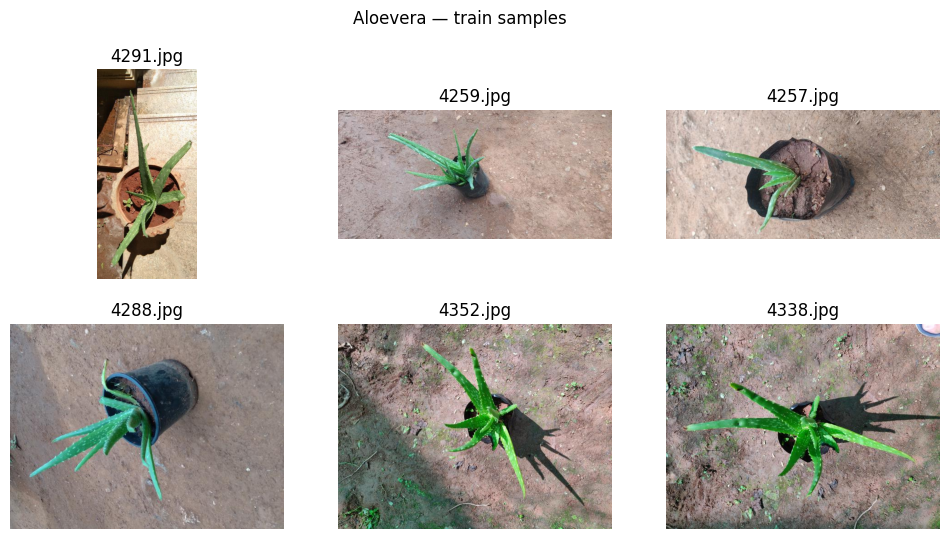

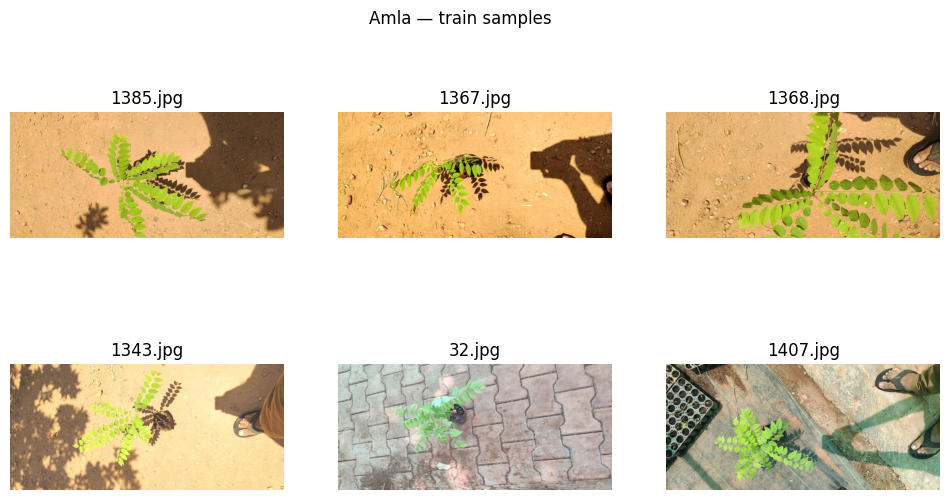

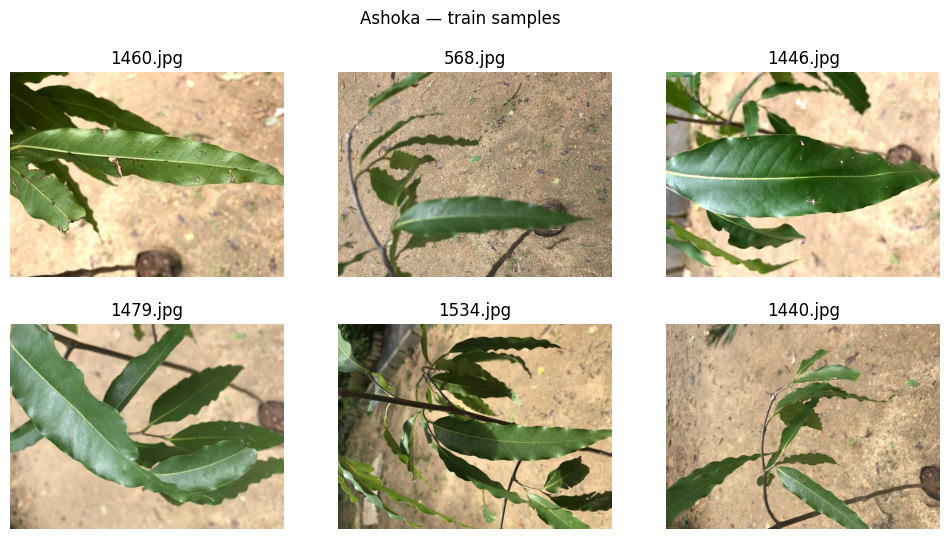

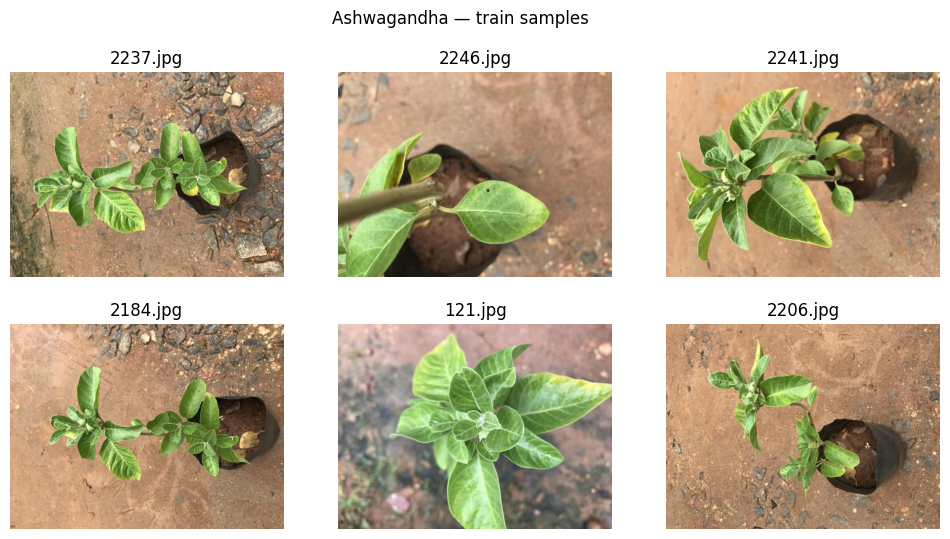

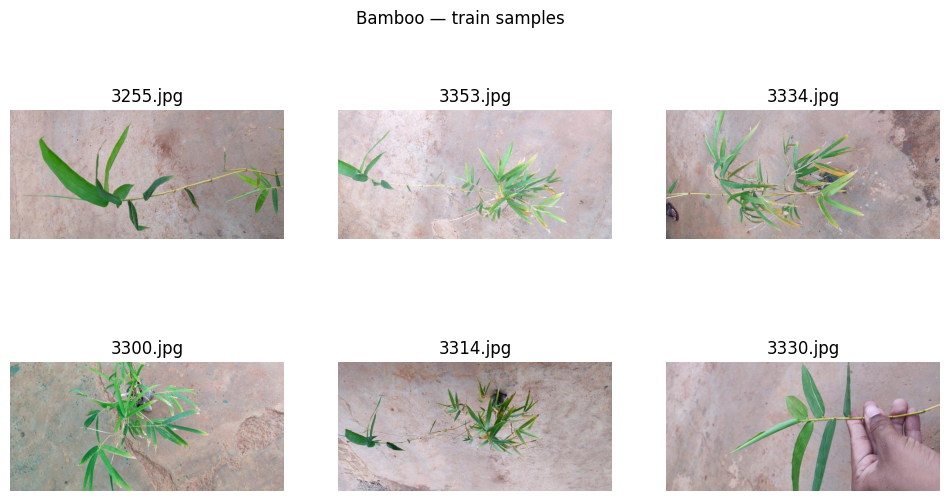

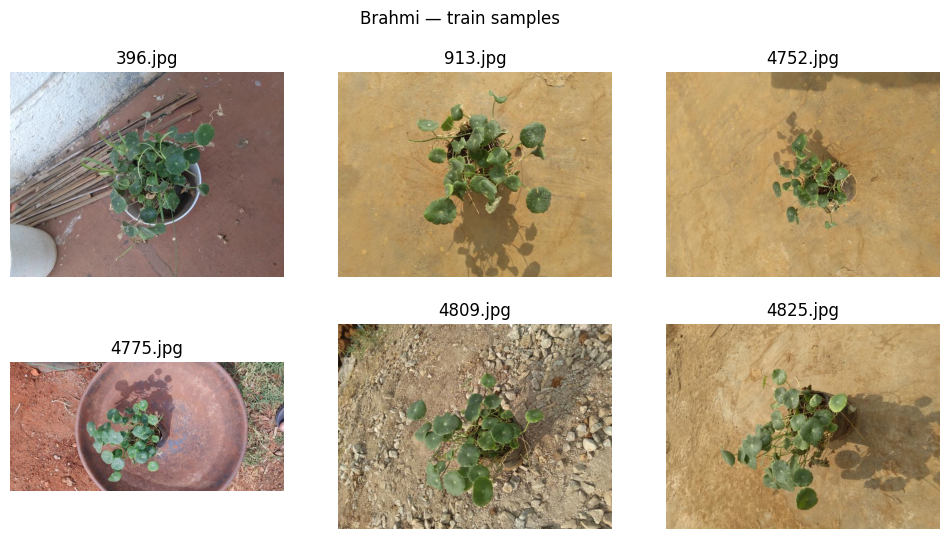

In [16]:
# Cell 5: pick some classes to preview
sample_classes = list(train_counts.keys())[:6]   # change indices if you want other classes
for cls in sample_classes:
    show_random_from_class(cls, split="train", n=6)


Batch images shape: torch.Size([16, 3, 224, 224])
Batch labels: tensor([ 1,  6, 18, 11,  8, 16,  5, 12, 15,  7])


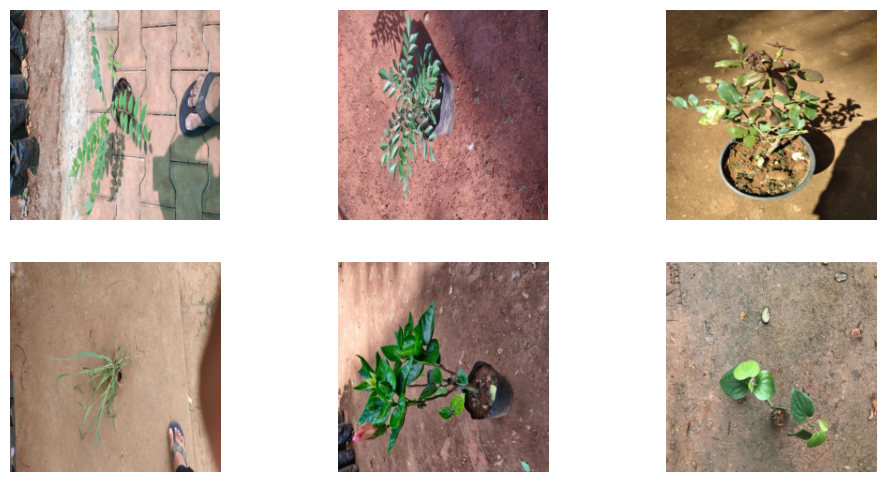

In [23]:
# Cell 6: quick PyTorch ImageFolder + DataLoader preview (optional)
import torch
from torchvision import transforms, datasets
from torch.utils.data import DataLoader

tfms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
])

train_dataset = datasets.ImageFolder(str(TRAIN_DIR), transform=tfms)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=0)

# show a single batch shape
imgs, labels = next(iter(train_loader))
print("Batch images shape:", imgs.shape)   # (B, C, H, W)
print("Batch labels:", labels[:10])
# visualize first 6 from batch
plt.figure(figsize=(12,6))
for i in range(min(6, imgs.size(0))):
    img = imgs[i].permute(1,2,0).numpy()
    plt.subplot(2,3,i+1); plt.imshow(img); plt.axis("off")
plt.show()


In [24]:
import pandas as pd
df = pd.DataFrame(list(train_counts.items()), columns=["Class", "Train_Count"])
df


Class  Train_Count
0      Aloevera          114
1          Amla          102
2        Ashoka          102
3   Ashwagandha          102
4        Bamboo          102
5        Brahmi          102
6    Curry_Leaf          102
7         Gauva          102
8      Hibiscus          115
9       Jasmine          130
10        Lemon          102
11  Lemon_grass          102
12        Mango          102
13         Mint          107
14         Neem          102
15      Pappaya          102
16       Pepper          102
17  Pomegranate          102
18         Rose          117
19       Tulasi          102

Found 5 misclassified images



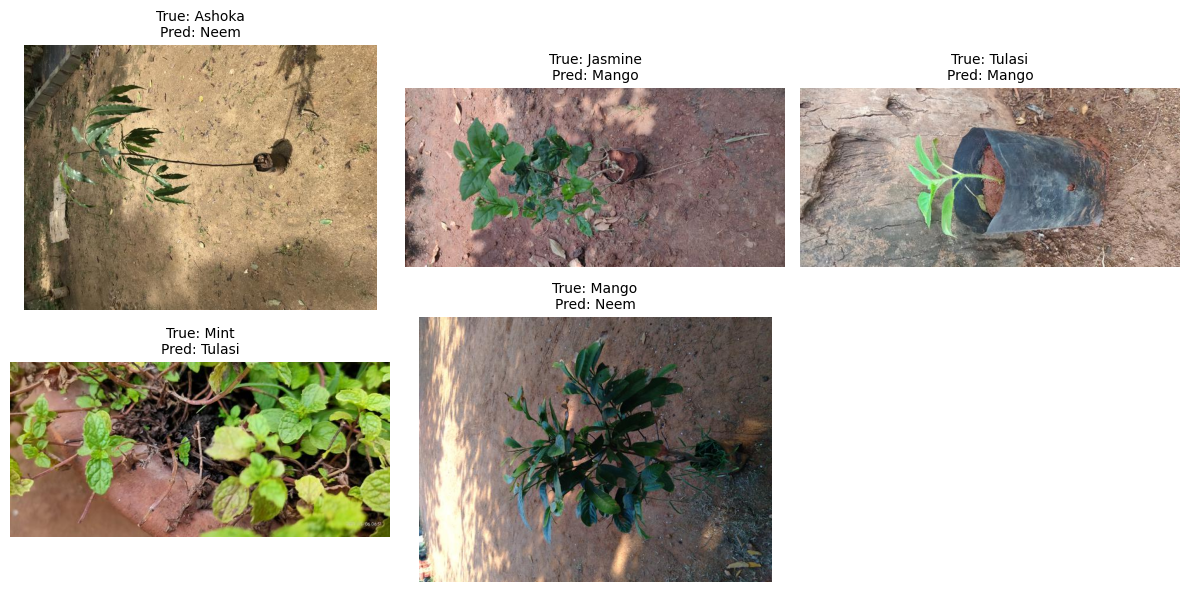

Summary (true -> pred):
  Ashoka -> Neem: 1
  Jasmine -> Mango: 1
  Tulasi -> Mango: 1
  Mint -> Tulasi: 1
  Mango -> Neem: 1


In [27]:
# display_misclassified (notebook cell)
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
import math
from collections import Counter

mis_dir = Path("misclassified")
files = sorted([p for p in mis_dir.iterdir() if p.suffix.lower() in [".jpg",".jpeg",".png"]])

print("Found", len(files), "misclassified images\n")

pairs = []
n = len(files)
cols = 3
rows = math.ceil(n/cols)
plt.figure(figsize=(cols*4, rows*3))
for i,p in enumerate(files, start=1):
    # filename pattern: <stem>__true-<TrueName>__pred-<PredName>.<ext>
    stem = p.stem
    # naive parse (robust enough for current naming)
    true = "unknown"; pred = "unknown"
    parts = stem.split("__")
    for part in parts:
        if part.startswith("true-"):
            true = part.replace("true-","")
        if part.startswith("pred-") or part.startswith("pred-"):
            pred = part.replace("pred-","")
    pairs.append((true, pred))

    img = Image.open(p).convert("RGB")
    plt.subplot(rows, cols, i)
    plt.imshow(img)
    plt.axis("off")
    title = f"True: {true}\nPred: {pred}"
    plt.title(title, fontsize=10)

plt.tight_layout()
plt.show()

# summary counts
cnt = Counter(pairs)
print("Summary (true -> pred):")
for (t,p),c in cnt.items():
    print(f"  {t} -> {p}: {c}")
